### 1 Loading Dataset

In [1]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import os
import random

from models.my_datasets import MyDataset2
from models.my_models_alex import MyModel_CNN
#from models.my_models_vgg16 import MyModel_CNN


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device)

True
cuda:0


In [4]:
'''
ROOT = './output/town04_image_data/images/'
OUT = './output/town04_image_data/smallimages/'
SIZE = (400,300)
image_paths = os.listdir(ROOT)
image_paths.sort()
for im in image_paths:
    #print(im)
    img = cv2.imread(ROOT+im)
    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)
    cv2.imwrite(OUT+im, img)
'''

"\nROOT = './output/town04_image_data/images/'\nOUT = './output/town04_image_data/smallimages/'\nSIZE = (400,300)\nimage_paths = os.listdir(ROOT)\nimage_paths.sort()\nfor im in image_paths:\n    #print(im)\n    img = cv2.imread(ROOT+im)\n    img = cv2.resize(img, SIZE,  interpolation = cv2.INTER_AREA)\n    cv2.imwrite(OUT+im, img)\n"

In [5]:
'''
ROOT = './output/town04_image_data/'
out = open(ROOT+"alldata.txt",'w')
lines=[]
with open(ROOT+"offdata_image.txt", 'r') as infile:
    for line in infile:
        line = line.rstrip()
        words = line.split()
        img = cv2.imread(ROOT+words[0])
        if img is None:
            pass
        else:
            out.write(line)
            out.write('\r\n')
out.close()
'''

'\nROOT = \'./output/town04_image_data/\'\nout = open(ROOT+"alldata.txt",\'w\')\nlines=[]\nwith open(ROOT+"offdata_image.txt", \'r\') as infile:\n    for line in infile:\n        line = line.rstrip()\n        words = line.split()\n        img = cv2.imread(ROOT+words[0])\n        if img is None:\n            pass\n        else:\n            out.write(line)\n            out.write(\'\r\n\')\nout.close()\n'

In [20]:
#preprocess the txt file
ROOT = './output/town04_image_data/'
train_out = open(ROOT+"traindata_shuffle.txt",'w')
val_out = open(ROOT+"valdata_shuffle.txt",'w')
over_out = open(ROOT+"overdata_shuffle.txt",'w')
lines=[]
with open(ROOT+"data_image_all.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    #random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count>=25 and count<=35:
                print(line)
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()        

In [21]:
TRANSFORM = cv2.resize
SIZE = (400,300)
over_data = MyDataset2(root = ROOT, txtname = 'overdata_shuffle.txt', transform=TRANSFORM, size=SIZE)
train_data = MyDataset2(root = ROOT, txtname = 'traindata_shuffle.txt' , transform = TRANSFORM, size= SIZE)
val_data = MyDataset2(root = ROOT, txtname = 'valdata_shuffle.txt', transform = TRANSFORM, size= SIZE)
over_loader = DataLoader(dataset=over_data, batch_size=32, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=32, shuffle=True)
print("Overfit size: %i" % len(over_data))
print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))

Overfit size: 4
Train size: 24556
Validation size: 6137


In [8]:
print(over_data[0][0][0].shape)
cv2.imshow('Window',over_data[0][0][0])
cv2.waitKey(0)
cv2.destroyAllWindows()

(300, 400, 3)


### 2 Defining Neural Network

In [9]:
mynet= MyModel_CNN().to(device)
print(mynet)

MyModel_CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (predict): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=22704, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512,

In [10]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

14,226,498 total parameters.
14,226,498 trainable parameters.


### 3 Training Neural network

In [11]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-6, eps = 1e-08) 

In [12]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
    
    #Iterating through the minibatches of the data
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = [x.cuda() for x in X]
        y = y.to(device)
        #Y = [y.cuda() for y in Y]
        #X = torch.tensor(X)
        #Y = torch.as_tensor(np.array(Y))
        #print(X.shape,y.shape)
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X)
            y_pred = y_pred.float()
            #print(y)
            #print(y_pred)
            y = y.float()
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
            #print('x', X)
            #print('prediction', y_pred)
            #print('gt', y)
        else:
            y_pred = model(X)
            y_pred = y_pred.float()  
            y = y.float()
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss    

In [13]:
# test if the model will overfit with only one sample
max_epochs = 200 
train_history = []
val_history = []
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(myoptimizer, max_epochs)
for epoch in range(max_epochs):
    '''
    if epoch >= 1999 and epoch <= 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-5
    elif epoch > 2999:
        myoptimizer.param_groups[0]['lr'] = 1e-6
        
    scheduler.step()
    '''
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 10 == 9:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss, val_loss))
        #print(scheduler.get_last_lr())

Epoch  10/200, train_loss: 2.484204e-01, val_loss: 7.438793e-02 
Epoch  20/200, train_loss: 1.155464e-01, val_loss: 4.109136e-02 
Epoch  30/200, train_loss: 5.056928e-03, val_loss: 1.726442e-02 
Epoch  40/200, train_loss: 7.326918e-03, val_loss: 1.482649e-03 
Epoch  50/200, train_loss: 2.162050e-03, val_loss: 2.454232e-03 
Epoch  60/200, train_loss: 2.691431e-04, val_loss: 6.420080e-04 
Epoch  70/200, train_loss: 1.519890e-04, val_loss: 8.964601e-05 
Epoch  80/200, train_loss: 6.657335e-05, val_loss: 2.311291e-05 
Epoch  90/200, train_loss: 1.313273e-05, val_loss: 1.241200e-05 
Epoch 100/200, train_loss: 2.473466e-06, val_loss: 1.192552e-05 
Epoch 110/200, train_loss: 3.610309e-06, val_loss: 5.619670e-06 
Epoch 120/200, train_loss: 2.298587e-06, val_loss: 5.737121e-07 
Epoch 130/200, train_loss: 2.095953e-07, val_loss: 4.987756e-07 
Epoch 140/200, train_loss: 2.633391e-07, val_loss: 1.313984e-07 
Epoch 150/200, train_loss: 2.514915e-08, val_loss: 8.295839e-08 
Epoch 160/200, train_loss

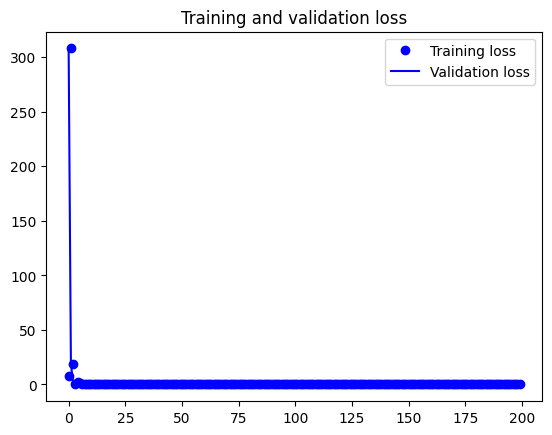

In [14]:
# plot the train&validation loss curve with only one sample
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [15]:
TEST = random.randint (0, 3)
test_in, gt_output = over_data[TEST]
test_in = [torch.tensor(x).cuda() for x in test_in]
gt_output = torch.tensor(gt_output).to(device)
output_pred = mynet(test_in) 
#print('TEST', TEST)
#print('test_in',test_in)
print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[[-8.3064660e-06 -1.8364313e-01]], ground truth:[ 1.94177714e-12 -1.83614025e-01]


In [16]:
# start the main training process

num_trainbatch = np.ceil(len(train_data)/32) 
num_valbatch = np.ceil(len(val_data)/32) 
train_history = []
val_history = []

min_loss = 100000
current_patience = 0
patience = 5



In [23]:
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-7, eps = 1e-08) 
max_epochs = 2
print('Start training!')
for epoch in range(max_epochs): 
    '''
    if epoch > 9 and epoch <= 19:
        myoptimizer.param_groups[0]['lr'] = 5e-5
    elif epoch > 19:
        myoptimizer.param_groups[0]['lr'] = 1e-6
    '''
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    #if epoch % 100 == 99:
    print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
      (train_loss/num_trainbatch, val_loss/num_valbatch))
'''
    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        torch.save(mynet.state_dict(),'mynet.pth')
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   '''

print('FINISH.')

Start training!
Epoch   1/2, train_loss: 3.870335e-03, val_loss: 3.715814e-03 


RuntimeError: CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 1.96 GiB total capacity; 862.85 MiB already allocated; 10.06 MiB free; 930.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

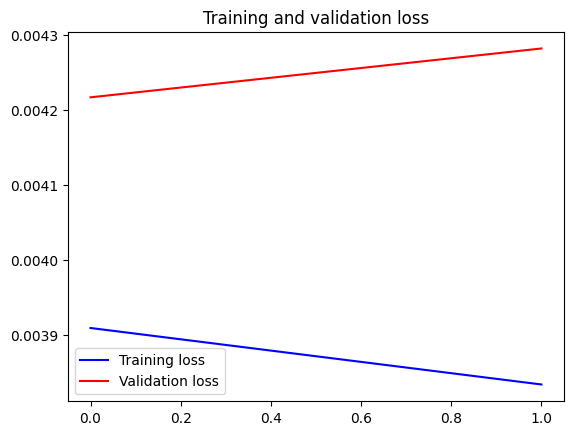

In [22]:
# plot the train&validation loss curve 
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'b', label='Training loss')
plt.plot(epochs, val_history, 'r', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()


In [25]:
# save trained model
torch.save(mynet.state_dict(),'./models/mynet_alexnet_all_5.pth')

In [15]:
mynet.load_state_dict(torch.load('./models/mynet_alexnet_all_4.pth'))

<All keys matched successfully>

In [19]:
for i in range (21):
    TEST = random.randint (0, 2900)
    test_in, gt_output = val_data[TEST]
    test_in = [torch.tensor(x).cuda() for x in test_in]
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    #print('TEST', TEST)
    #print('test_in',test_in)
    print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

prediction:[[1.0451425  0.05493085]], ground truth:[1.         0.05130721]
prediction:[[ 1.0106381 -0.3864771]], ground truth:[ 1.        -0.3706857]
prediction:[[ 4.1950214e-01 -2.6309118e-04]], ground truth:[ 0.47017243 -0.04200191]
prediction:[[ 0.05943284 -0.02394141]], ground truth:[ 4.09873380e-13 -5.81281568e-02]
prediction:[[0.3540799  0.02195956]], ground truth:[0.35644556 0.00636777]
prediction:[[0.41602182 0.06518103]], ground truth:[0.4249547  0.05413849]
prediction:[[1.0684751  0.06621121]], ground truth:[1.         0.01296327]
prediction:[[-0.03565545 -0.09232545]], ground truth:[ 4.94692660e-13 -4.96037369e-02]
prediction:[[ 1.0412581  -0.02417692]], ground truth:[ 1.         -0.00370599]
prediction:[[0.9985546  0.23713678]], ground truth:[0.99996426 0.22649477]
prediction:[[0.3921817  0.02228834]], ground truth:[3.57651344e-01 4.26219437e-05]
prediction:[[0.29400325 0.01852754]], ground truth:[ 0.28448046 -0.0015667 ]
prediction:[[ 0.9948844 -0.9880783]], ground truth:[